In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

In [41]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

# some data cleaning, factorizing and ordering
df['gender'] = df['gender'].astype('category')
gender_order = ['Female', 'Male', 'Other']
df['hypertension'] = df['hypertension'].astype('category')
hypertension_order = [0, 1] # 0= no, 1= yes
df['heart_disease'] = df['heart_disease'].astype('category')
heart_disease_order = [0, 1]  # 0= no, 1= yes
df['smoking_history'] = df['smoking_history'].astype('category')
smoking_history_order = ['No Info', 'current', 'ever', 'former', 'never', 'not current']
df['diabetes'] = df['diabetes'].astype('category')
diabetes_order = [0, 1]


Below I performed an explanatory data analysis to better understand my data. This includes creating box plots and histograms of my continuous variables (age, bmi, HbA1c_level, blood_glucose_level). I also created a correlation matrix to see if multicollearity exists within these variables. Moreover, I created bar plots for my categorical variables (gender, HTN, heart_disease, smoking_history, diabetes) to see if there are any imbalances in the distribution. 

In [11]:
def cont_distribution(var):
    # histogram
    plt.hist(df[var])
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

    # box plot for outliers
    sns.boxplot(x=df[var])
    plt.title(f'Box plot for {var}')
    plt.show()

# subplot
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

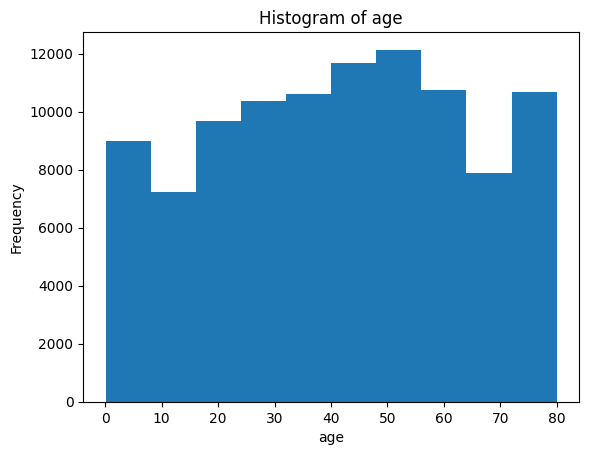

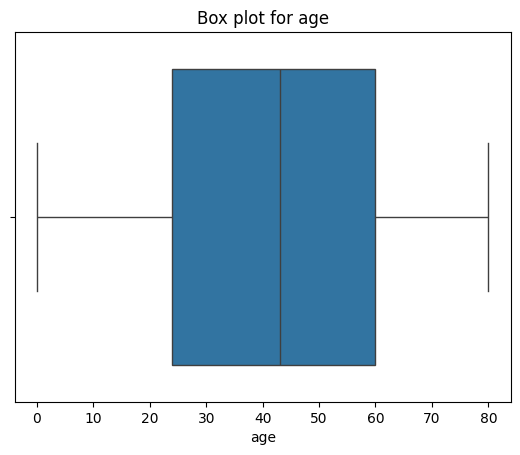

In [7]:
cont_distribution('age')
plt.show()

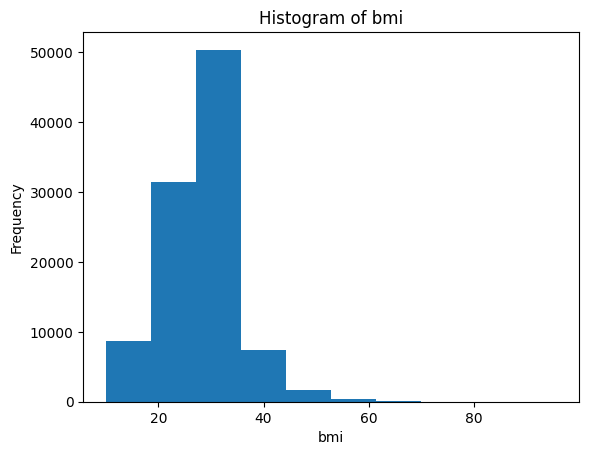

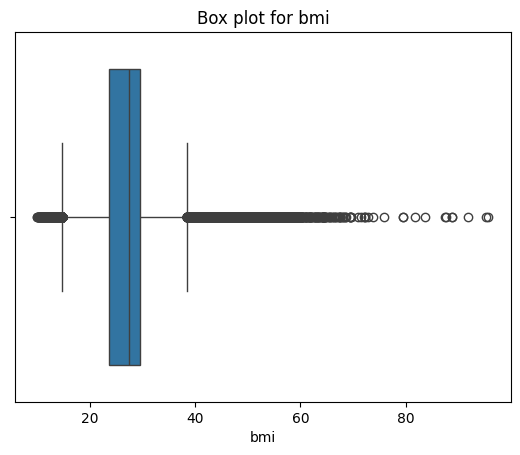

In [8]:
cont_distribution('bmi')
plt.show()

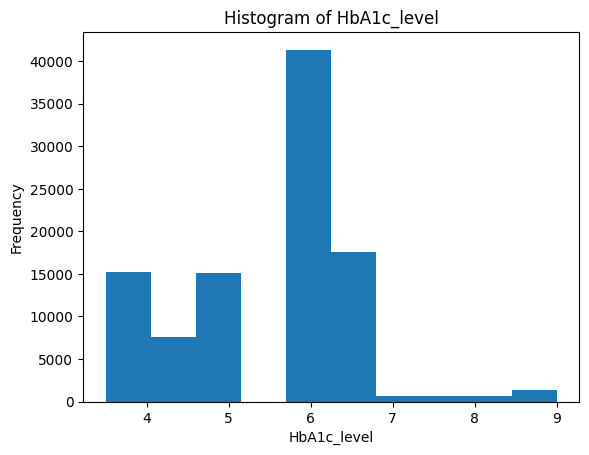

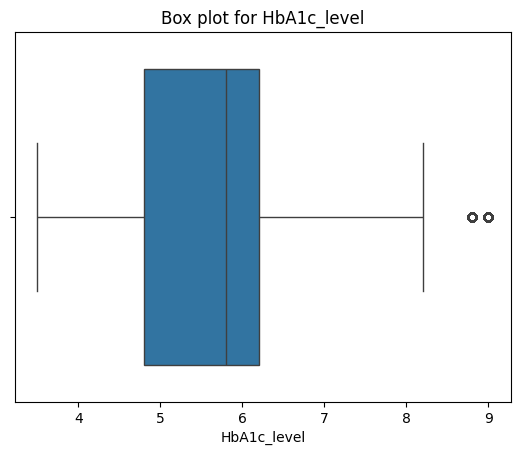

In [9]:
cont_distribution('HbA1c_level')
plt.show()

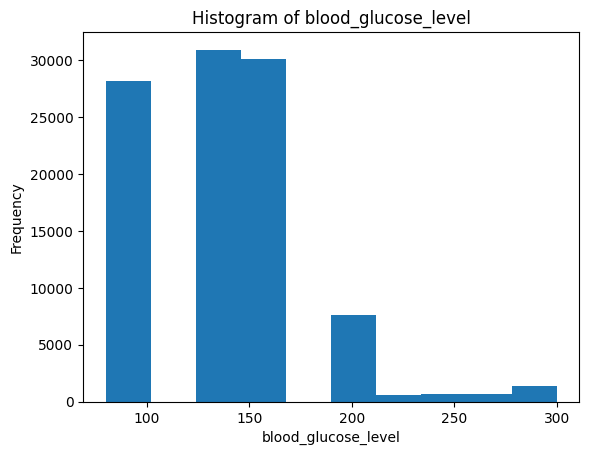

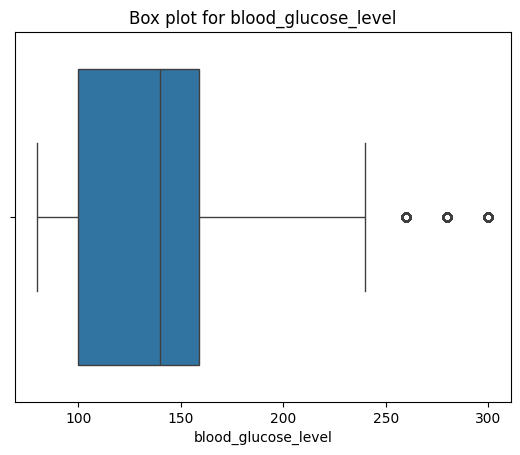

In [10]:
cont_distribution('blood_glucose_level')
plt.show()

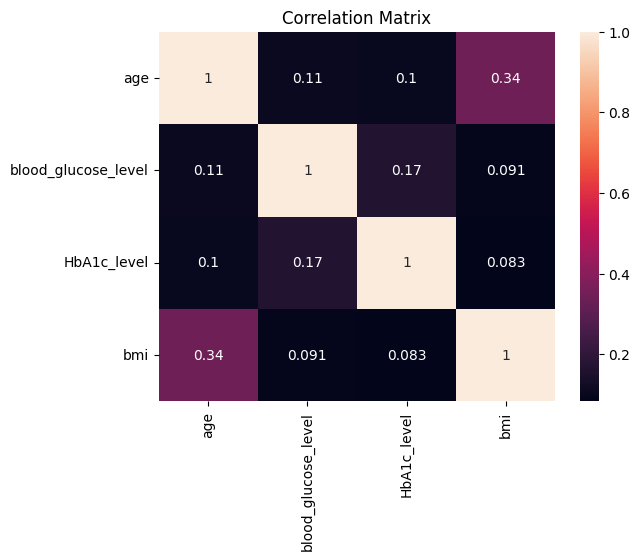

In [5]:
# check Multicollinearity
corr_matrix = df[['age', 'blood_glucose_level', 'HbA1c_level', 'bmi']]
sns.heatmap(corr_matrix.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

Above is a correlation matrix showing all the correlation (r) coefficienct between each continuous variables. We see that there is a relatively low to moderate correlation between these variables, so there is less likely to be multicollinearity. 

Now, we will explore the categorical variables. Below are plots to show the distribution of categorical variables: gender, HTN, heart_disease, smoking_history, diabetes

Text(0.5, 1.0, 'Gender Distribution')

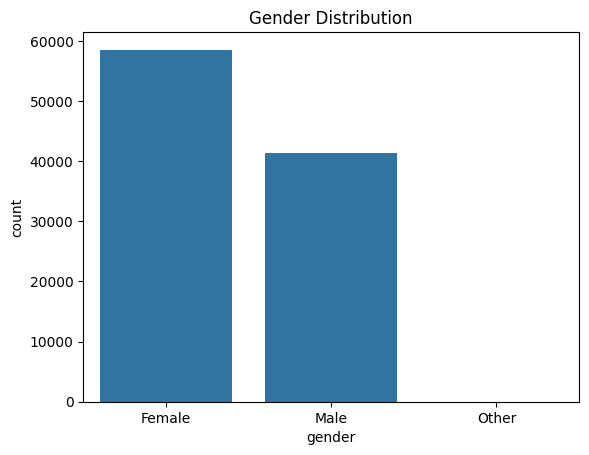

In [37]:
sns.countplot(df, x='gender', order=gender_order).set_title('Gender Distribution')

Text(0.5, 1.0, 'Hypertension Distribution')

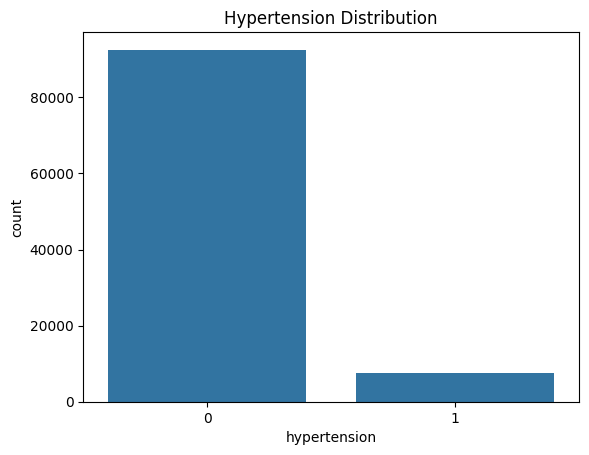

In [17]:
sns.countplot(df, x='hypertension', order=hypertension_order).set_title('Hypertension Distribution')

Text(0.5, 1.0, 'Heart Disease Distribution')

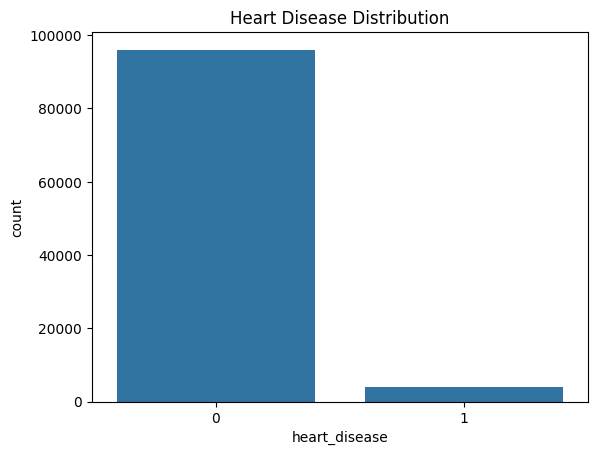

In [18]:
sns.countplot(df, x='heart_disease', order=heart_disease_order).set_title('Heart Disease Distribution')

Text(0.5, 1.0, 'Smoking History Distribution')

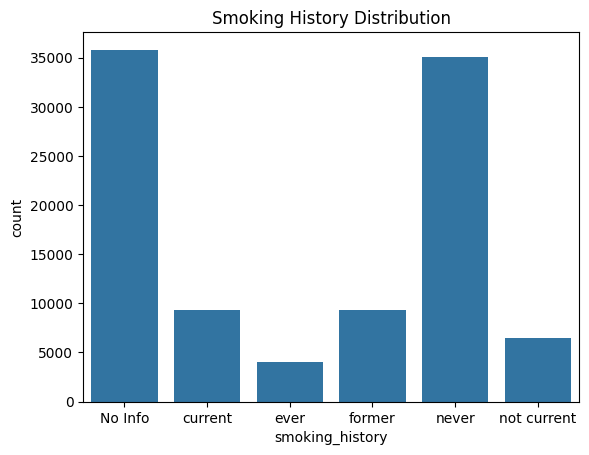

In [38]:
sns.countplot(df, x='smoking_history', order=smoking_history_order).set_title('Smoking History Distribution')

Text(0.5, 1.0, 'Diabetes Distribution')

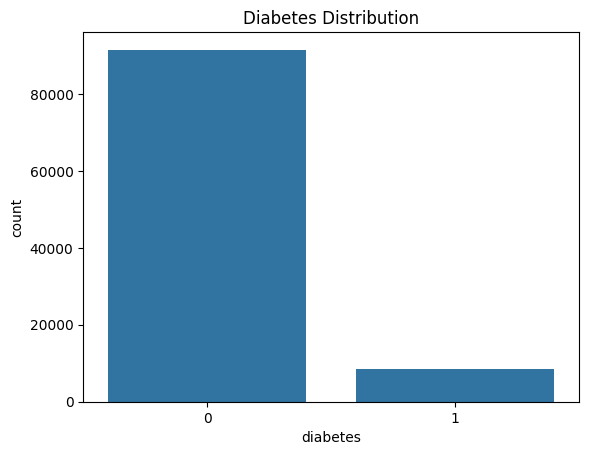

In [22]:
sns.countplot(df, x='diabetes', order=diabetes_order).set_title('Diabetes Distribution')

As seen in the distribution of the categorical variables, most of the variables are not distributed equally (hypertension, heart disease, diabetes, smoking history). This may create model bias, where it'll become bias towards predicting the majority class. My plan will be to assign a balanced weight to train the dataset in my algorithm.

Below, I chose to do gradient boost, random forest, XGboost as my ML algorithms to see which performs the best. I Split the data into training and testing; 20% test, 80% train

In [62]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
y = df['diabetes']
X = pd.get_dummies(X, columns=['gender', 'smoking_history'], drop_first=True) # one hot encode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df['binary_smoking_history'] = df['smoking_history'].apply(lambda x: 0 if x in ['no info', 'not current', 'never'] else 1) # binary labels for smoking history to use in class weights

# class weights 
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
sample_weights = class_weights[y_train.astype(int)]

# gradient boost
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
gb_pred = gb_model.predict(X_test) # predictions
gb_cf = confusion_matrix(y_test, gb_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)

# random forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test) # predictions
rf_cf = confusion_matrix(y_test, rf_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)

#XGBoost 
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_cf = confusion_matrix(y_test,xgb_pred)
xgb_accuracy = accuracy_score(y_test,xgb_pred)


In [63]:
print("Gradient Boosting Classifier:")
print(f"Confusion Matrix:\n{gb_cf}")
print(f"Accuracy: {gb_accuracy:.2f}")

print("\nRandom Forest Classifier:")
print(f"Confusion Matrix:\n{rf_cf}")
print(f"Accuracy: {rf_accuracy:.2f}")

print("\nXGBoost Classifier:")
print(f"Confusion Matrix:\n{xgb_cf}")
print(f"Accuracy: {xgb_accuracy:.2f}")

Gradient Boosting Classifier:
Confusion Matrix:
[[16448  1844]
 [  125  1583]]
Accuracy: 0.90

Random Forest Classifier:
Confusion Matrix:
[[18216    76]
 [  536  1172]]
Accuracy: 0.97

XGBoost Classifier:
Confusion Matrix:
[[16908  1384]
 [  211  1497]]
Accuracy: 0.92


Random Forest achieved the highest accuracy of 97%. The model correctly predicted 1172 cases of diabetes (positive class) and 18216 cases of non-diabetes (negative class). There were 76 cases where the model incorrectly predicted diabetes when it was not present, and 536 cases where it incorrectly predicted non-diabetes when diabetes was present. Successfully identifying a high number of true positives and true negatives.

XGBoost had a good performance with an accuracy score of 92%. The model correctly predicted 1497 cases of diabetes (positive class) and 16908 cases of non-diabetes (negative class). There were 1384 cases where the model incorrectly predicted diabetes when it was not present, and 211 cases where it incorrectly predicted non-diabetes when diabetes was present. It showed a between true positives and true negatives, with some false positives and false negatives.

Gradient Boost achieved an accuracy of 90%. The model correctly predicted 1583 cases of diabetes (positive class) and 16448 cases of non-diabetes (negative class). There were 1844 cases where the model incorrectly predicted diabetes when it was not present, and 125 cases where it incorrectly predicted non-diabetes when diabetes was present. The model showed good sensitivity (true positives), but had a higher number of false positives compared to the other models. 

Conclusion: Random Forest is the best performing model out of the 3, based on accuracy. 
